In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from Callbacks import Callbacks
from Config import Config
from DataLoader import DataLoader
from folder_defs import get_logdir, get_data_dir, get_image_dir
from train_model import train_model
from build_model import build_model
from save_model import save_model
from keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('Beginning program')

Beginning program


In [3]:
# get config
config = Config().config
print('change lr:', config.change_lr)
print('change bs:', config.change_bs)
print('max epochs:', config.epochs)
if config.change_bs == config.change_lr:
    print(f'[!] Whoops: config.change_bs and config.change_lr should be '
          f'different bool values, but they are both {config.change_bs} '
          f'-- please set one and only one of them to True')

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-344a7e9b-f5a2-4273-baf9-5ab4ce5ffc0a.json']
change lr: False
change bs: False
max epochs: 10
[!] Whoops: config.change_bs and config.change_lr should be different bool values, but they are both False -- please set one and only one of them to True


In [4]:
# get constants
max_epochs = config.epochs
batch_size = config.batch_size
batch_size_increase_multiplier = 2
model_iter = 0
epoch_iter = 1

In [5]:
# CHANGING CONSTANTS FOR TESTING
config.change_lr = False
config.change_bs = True

In [6]:
# get directories
log_dir = get_logdir(config)
data_dir = get_data_dir()
image_dir = get_image_dir()
print('log dir:', log_dir)
print('data dir:', data_dir)
print('image dir:', image_dir)

log dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/logs/0305_135350-changelr_False-changebs_True-batch_var
data dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/
image dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/


In [7]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [8]:
# get data
print('Loading data...')
dataloader = DataLoader(data_dir=data_dir, image_dir=image_dir)
x_data, y_data = dataloader.retrieve_data()

Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/
	sub dirs:
		 00
shape of x_data:  (560, 228, 228, 3)


In [9]:
# get input dim
input_dim = x_data[0].shape
print('input dim:', input_dim)
print('len of data:', x_data.shape[0])

input dim: (228, 228, 3)
len of data: 560


In [10]:
# split data into training and test sets - shuffles by default
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=config.test_split)
num_train = int(x_train.shape[0] * (1 - config.val_split))
print(f'Num training examples (excludes test and val): {num_train}')

Num training examples (excludes test and val): 358


In [11]:
# build model
model = build_model(input_dim, config)

Building model...
Finished building model
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2

In [12]:
# save initial model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [13]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []

In [15]:
# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will reduce learning rate during training, but not batch size')
    print('Training model...')
    model, history = train_model(model, x_train, y_train,
                                 batch_size, max_epochs, callbacks, config)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    for i in range(len(history.history['lr'])):
        bs.append(batch_size)
elif config.change_bs:  # need to manually stop and restart training
    print('Will reduce batch size during training, but not learning rate')
    # load model with its current weights
    model = load_model(os.path.join(log_dir, 'model.hdf5'))
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}')
        print(f'Batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        model, history = train_model(model, x_train, y_train,
                                     batch_size, epochs, callbacks, config)
        epoch_iter += len(history.epoch)
        bs += [batch_size for i in range(len(history.epoch))]
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        model_iter += 1
        batch_size *= batch_size_increase_multiplier
        batch_size = batch_size if batch_size < num_train else num_train
        save_model(log_dir=log_dir, config=config, model=model)
    lr = [0.001 for i in range(len(bs))]
    print(f'Total times batch size was increased: {model_iter - 1}')
else:
    print(f'[!] Whoops: config.change_bs and config.change_lr are both '
          f'set to False - please set one of them to True')
print('Completed training')

Will reduce batch size during training, but not learning rate
Currently at epoch 1 of 10
Batch size is 4
Train on 358 samples, validate on 90 samples
Epoch 1/10
358/358 [==============================] - 42s 117ms/step - loss: 5.1989 - acc: 0.5587 - val_loss: 5.7055 - val_acc: 0.6222
Epoch 2/10
358/358 [==============================] - 46s 129ms/step - loss: 5.7412 - acc: 0.6089 - val_loss: 5.9100 - val_acc: 0.6333
Epoch 3/10
358/358 [==============================] - 48s 133ms/step - loss: 5.8581 - acc: 0.6117 - val_loss: 9.9217 - val_acc: 0.3778
Epoch 4/10
358/358 [==============================] - 42s 117ms/step - loss: 6.6059 - acc: 0.5754 - val_loss: 7.0675 - val_acc: 0.5444
Epoch 5/10
358/358 [==============================] - 44s 122ms/step - loss: 8.1498 - acc: 0.4804 - val_loss: 7.7632 - val_acc: 0.5000
Epoch 00005: early stopping
Saving model...
Model saved
Currently at epoch 6 of 10
Batch size is 8
Train on 358 samples, validate on 90 samples
Epoch 1/5
358/358 [============

In [16]:
# evaluate model
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Final score:', score)

Calculating final score...
112/112 [==============================] - 3s 28ms/step
Final score: [7.769655772617885, 0.5178571428571429]


In [17]:
# save finished model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [18]:
# save loss, accuracy, and lr values to dict
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                 }
for k, v in acc_loss_lr_bs.items():
    print(k, len(v), type(v[0]))

val_loss 10 <class 'numpy.float64'>
val_acc 10 <class 'numpy.float64'>
loss 10 <class 'numpy.float64'>
acc 10 <class 'numpy.float64'>
lr 10 <class 'numpy.float64'>
bs 10 <class 'int'>


In [19]:
# save dict to json
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

In [20]:
print('Completed program')

Completed program


In [21]:
# PLOTTING FOR TESTING
import matplotlib.pyplot as plt

In [22]:
# load dict from json
d = None
with open(acc_loss_lr_bs_path, 'r') as f:
    d = json.load(f)

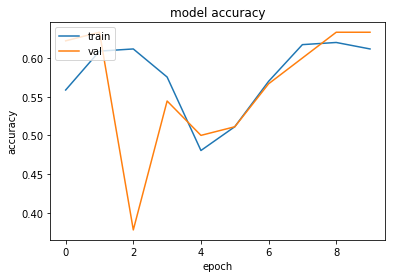

In [23]:
# summarize history for accuracy
plt.plot(d['acc'])
plt.plot(d['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

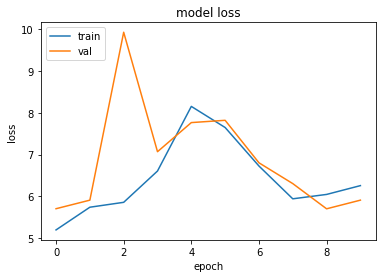

In [24]:
# summarize history for loss
plt.plot(d['loss'])
plt.plot(d['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

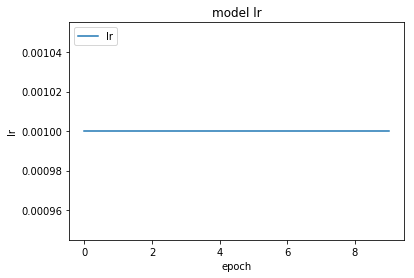

In [25]:
# summarize history for lr
plt.plot(d['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper left')
plt.show()

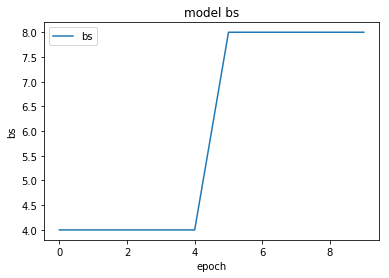

In [26]:
# summarize history for bs
plt.plot(d['bs'])
plt.title('model bs')
plt.ylabel('bs')
plt.xlabel('epoch')
plt.legend(['bs'], loc='upper left')
plt.show()